<a href="https://www.kaggle.com/code/aisuko/image-classification-with-lora?scriptVersionId=164958039" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Overview

We are going to fine-tune an image classification model by using low-rank approximation technique. By using LoRA, we can reduce the number of trainable parameters in the model to only 0.77% of the original. LoRA achieves this reduction by adding low-rank "update-matrices" to specific blocks of the model, such as the attention blocks. During fine-tuning, only these matrices are trained, while the original model parameters are left unchanged. At inference time, the update matrices are merged with the original model parameters to produce the final classification result.

In [1]:
%%capture
!pip install transformers==4.36.2
!pip install accelerate==0.25.0
!pip install evaluate==0.4.1
!pip install peft==0.7.1

In [2]:
import os
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()

login(token=user_secrets.get_secret("HUGGINGFACE_TOKEN"))

os.environ["WANDB_API_KEY"]=user_secrets.get_secret("WANDB_API_KEY")
os.environ["WANDB_PROJECT"] = "Fine-tune-models-with-LoRA"
os.environ["WANDB_NOTES"] = "Fine tune model with low rank approximation"
os.environ["WANDB_NAME"] = "ft-vit-base-patch16-224-in21k-on-food101-lora"
os.environ["MODEL_NAME"] = "google/vit-base-patch16-224-in21k"

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [3]:
!accelerate estimate-memory ${MODEL_NAME} --library_name transformers

Loading pretrained config for `google/vit-base-patch16-224-in21k` from `transformers`...
config.json: 100%|█████████████████████████████| 502/502 [00:00<00:00, 2.36MB/s]
┌────────────────────────────────────────────────────────────────┐
│  Memory Usage for loading `google/vit-base-patch16-224-in21k`  │
├───────┬─────────────┬──────────┬───────────────────────────────┤
│ dtype │Largest Layer│Total Size│      Training using Adam      │
├───────┼─────────────┼──────────┼───────────────────────────────┤
│float32│   27.04 MB  │329.55 MB │            1.29 GB            │
│float16│   13.52 MB  │164.77 MB │            659.1 MB           │
│  int8 │   6.76 MB   │ 82.39 MB │           329.55 MB           │
│  int4 │   3.38 MB   │ 41.19 MB │           164.77 MB           │
└───────┴─────────────┴──────────┴───────────────────────────────┘


# Loading the datasets

Let's keep the runtime of example short with load the first 5k instances from the training set.

In [4]:
from datasets import load_dataset

dataset_name="food101"
dataset=load_dataset(dataset_name, split="train[:500]")

Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/.cache/huggingface/datasets/food101/default/0.0.0/7cebe41a80fb2da3f08fcbef769c8874073a86346f7fb96dc0847d4dfc318295. Subsequent calls will reuse this data.


# Preparing the data

Let's create `label2id` and `id2label` dictionaries.

In [5]:
labels=dataset.features["label"].names
label2id,id2label=dict(), dict()

for i, label in enumerate(labels):
    label2id[label]=i
    id2label[i]=label

id2label[2]

'baklava'

The `image_processor` contains useful information on which size the training and evaluation images should be resized to, as well as values that should be used to normalize the pixel values. Using the `image_processor`, prepare transformation functions for the datasets.

In [6]:
from transformers import AutoImageProcessor

image_processor=AutoImageProcessor.from_pretrained(os.getenv("MODEL_NAME"))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [7]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize=Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

train_transforms=Compose(
    [
        RandomResizedCrop(image_processor.size["height"]),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize,
    ]
)

val_transforms=Compose(
    [
        Resize(image_processor.size["height"]),
        CenterCrop(image_processor.size["height"]),
        ToTensor(),
        normalize,
    ]
)

def preprocess_train(example_batch):
    example_batch["pixel_values"]=[train_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

def preprocess_val(example_batch):
    example_batch["pixel_values"]=[val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [8]:
splits=dataset.train_test_split(test_size=0.1)
train_ds=splits["train"]
val_ds=splits["test"]

In [9]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

# Loading the Model

In [10]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model=AutoModelForImageClassification.from_pretrained(
    os.getenv("MODEL_NAME"),
    label2id=label2id,
    id2label=id2label,
    # provide this in case you are planning to fine-tune an already fine-tuned checkpoint
    ignore_mismatched_sizes=True,
)
print(model)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

We need to specify the target modules in LoraConfig, so `get_peft_model()` knows which modules inside our model need to be amended with LoRA matrices.

In this case, We are only interested in targeting the query and value matrices of the attention blocks of the base model. Since the parameters corresponding to these matrices are "named" "query" and "value" respectively, we specify them accordingly in the target_modules argument of LoraConfig.

We also specify `module_to_save`. After wrapping the base model with `get_peft_model()` along with the `config`, we get a new model where only the LoRA parameters are trainable(so-called "update matrices") while the pre-trained parameters are kept frozen. However, we want the classifier parameters to be trained too when fine-tuning the base model on our custom dataset. To ensure that the classifier parameters are also trained, we specify `module_to_save`. This also ensures that these modules are serialized alongside the LoRA trainable parameters when using utilities like `save_pretrained()`.

* **r**: The dimension used by the LoRA update matrices.
* **alpha**: Scaling factor.
* **bias**: Specifies if the `bias` parameters should be trained. `None` denotes none of the bias parameters will be trained.


**r** and **alpha** together control the total number of final trainable parameters when using LoRA, giving you the flexibility to balance a trade-off between and performance and compute efficiency.

In [11]:
print(model)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [12]:
from peft import LoraConfig, get_peft_model

peft_config=LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["query","value","key", "dense"],
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"],
)

peft_model=get_peft_model(model, peft_config)
peft_model.print_trainable_parameters()

trainable params: 2,731,877 || all params: 88,608,202 || trainable%: 3.083097205832029


# Define Data Batch

In [13]:
import torch

def collate_fn(examples):
    pixel_values=torch.stack([example["pixel_values"] for example in examples])
    labels=torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

# Define Metrics

In [14]:
import numpy as np
import evaluate

metric=evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions=np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

# Define training arguments

In [15]:
from transformers import TrainingArguments, Trainer

training_args=TrainingArguments(
    output_dir=os.getenv("WANDB_NAME"),
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=4,
    fp16=True,
    num_train_epochs=2,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    label_names=["labels"],
    report_to="wandb",
    run_name=os.getenv("WANDB_NAME"),
)

trainer=Trainer(
    peft_model,
    training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

train_results=trainer.train()

wandb: Currently logged in as: urakiny (causal_language_trainer). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.16.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.2
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240301_060339-jj7yhl8k
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run ft-vit-base-patch16-224-in21k-on-food101-lora
wandb: ⭐️ View project at https://wandb.ai/causal_language_trainer/Fine-tune-models-with-LoRA
wandb: 🚀 View run at https://wandb.ai/causal_language_trainer/Fine-tune-models-with-LoRA/runs/jj7yhl8k
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.103229,1.000000
2,No log,0.881609,1.000000


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [16]:
trainer.evaluate(val_ds)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 2.1032285690307617,
 'eval_accuracy': 1.0,
 'eval_runtime': 0.6649,
 'eval_samples_per_second': 75.202,
 'eval_steps_per_second': 1.504,
 'epoch': 2.0}

In [17]:
kwargs={
    'model_name': os.getenv('WANDB_NAME'),
    'finetuned_from': os.getenv('MODEL_NAME'),
    'tasks': 'Image Classification',
#     'dataset_tags':'',
    'dataset':'food101'
}

image_processor.push_to_hub(os.getenv("WANDB_NAME"))
trainer.push_to_hub(**kwargs)

training_args.bin:   0%|          | 0.00/4.41k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/10.9M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/aisuko/ft-vit-base-patch16-224-in21k-on-food101-lora/commit/67742916a9f552e3c1d6a2550ba5335aa5a62ed1', commit_message='End of training', commit_description='', oid='67742916a9f552e3c1d6a2550ba5335aa5a62ed1', pr_url=None, pr_revision=None, pr_num=None)

# Inference

In [18]:
del trainer, image_processor
torch.cuda.empty_cache()

In [19]:
from peft import PeftConfig, PeftModel

config=PeftConfig.from_pretrained("aisuko/"+os.getenv("WANDB_NAME"))
model=AutoModelForImageClassification.from_pretrained(
    config.base_model_name_or_path,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,
)

inference_model=PeftModel.from_pretrained(model, "aisuko/"+os.getenv("WANDB_NAME"))

adapter_config.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adapter_model.safetensors:   0%|          | 0.00/10.9M [00:00<?, ?B/s]

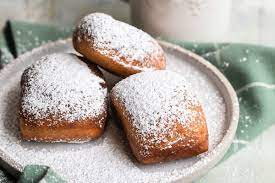

In [20]:
from PIL import Image
import requests

url="https://huggingface.co/datasets/sayakpaul/sample-datasets/resolve/main/beignets.jpeg"
image=Image.open(requests.get(url, stream=True).raw)
image

In [21]:
image_processor=AutoImageProcessor.from_pretrained("aisuko/"+os.getenv("WANDB_NAME"))

preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

In [22]:
encoding=image_processor(image.convert("RGB"), return_tensors="pt")

In [23]:
with torch.no_grad():
    outputs=inference_model(**encoding)
    logits=outputs.logits

predicted_class_idx=logits.argmax(-1).item()
inference_model.config.id2label[predicted_class_idx]

'beignets'